# Alaska evaluation

Evaluate the EKE methodology w.r.t the baseline (i.e TF-IDF)

## Define filepaths

In [1]:
root_dir = '../..'
data_dir = 'data'
corpus_dir = 'corpus'
rank_dir = 'terms'

## Load ground truth

In [2]:
import os
import json

In [3]:
gt_filename = 'alaska_camera_gt.json'
gt_filepath = os.path.join(root_dir, data_dir, corpus_dir, gt_filename)

In [4]:
with open(gt_filepath, 'r') as fd:
    gt_dict = json.load(fd)

In [5]:
from pprint import pprint

In [6]:
pprint(gt_dict)

{'ENTITY#101': 'canon eos 5d mark iii',
 'ENTITY#102': 'canon eos 5d mark ii',
 'ENTITY#16': 'nikon d90',
 'ENTITY#18': 'canon eos 60d',
 'ENTITY#19': 'nikon d3300',
 'ENTITY#21': 'nikon d5100',
 'ENTITY#23': 'canon eos 7d',
 'ENTITY#36': 'nikon d3100',
 'ENTITY#37': 'nikon d80',
 'ENTITY#41': 'nikon d5200',
 'ENTITY#44': 'nikon d3200',
 'ENTITY#57': 'nikon d800',
 'ENTITY#58': 'nikon 1 j1',
 'ENTITY#6': 'nikon d5300',
 'ENTITY#7': 'olympus omd em5',
 'ENTITY#75': 'nikon d7000',
 'ENTITY#76': 'nikon d610',
 'ENTITY#8': 'nikon 1 j3',
 'ENTITY#84': 'nikon d300',
 'ENTITY#96': 'canon eos 70d'}


## Load rankings

### LIME-based

In [7]:
import pandas as pd

In [8]:
lime_filename = 'ranking_alaska_nn.xlsx'
lime_filepath = os.path.join(root_dir, data_dir, rank_dir, lime_filename)

In [9]:
lime_df = pd.read_excel(lime_filepath, index_col=0)
# Replace '_' character with whitespaces
lime_df['term'] = lime_df['term'].map(lambda x: x.replace('_', ' '))
lime_df.head()

,label,term,weight,rank,count
0,ENTITY#101,5d mark iii,38.210490,1.0,40
1,ENTITY#101,5d mark,10.682544,1.0,14
2,ENTITY#101,canon eos 5d mark iii 22 3 mp full frame,3.825436,1.0,4
3,ENTITY#101,canon eos 5d mark iii body,3.609619,1.0,4
4,ENTITY#101,5d mark iii body,2.965371,1.0,3


In [10]:
lime_df.shape

(2039, 5)

### Baseline

In [11]:
baseline_filename = 'ranking_alaska_baseline.xlsx'
baseline_filepath = os.path.join(root_dir, data_dir, rank_dir, baseline_filename)

In [12]:
baseline_df = pd.read_excel(baseline_filepath, index_col=0)
baseline_df['term'] = baseline_df['term'].map(lambda x: x.replace('_', ' '))
baseline_df['term'] = baseline_df['term'].map(lambda x: x.replace('-', ''))
baseline_df.head()

,label,term
0,ENTITY#44,d3200
1,ENTITY#44,nikon d3200
2,ENTITY#44,18
3,ENTITY#44,nikon
4,ENTITY#44,24 2 mp digital slr camera black kit


In [13]:
baseline_df.shape

(55360, 2)

## Compute metrics for LIME and the baseline

In [14]:
src_dir = 'src'

In [15]:
import sys
sys.path.append(os.path.join(root_dir, src_dir))

In [16]:
lime_metrics_list = []
baseline_metrics_list = []

In [17]:
grouped_lime_df = lime_df.groupby('label')
grouped_baseline_df = baseline_df.groupby('label')

In [18]:
from metrics import compute_metrics

In [19]:
for group_name, group_data in grouped_lime_df:
    lime_terms = group_data['term'].values
    num_terms = lime_terms.shape[0]
    lime_metrics = compute_metrics(group_name, gt_dict, lime_terms)
    lime_metrics_list.append(lime_metrics)
    
    baseline_terms = grouped_baseline_df.get_group(group_name)['term']
    baseline_terms = baseline_terms.values[:num_terms]
    baseline_metrics = compute_metrics(group_name, gt_dict, baseline_terms)
    baseline_metrics_list.append(baseline_metrics)

## Plot metrics

In [20]:
from plot import compare_boxplots, compare_lineplots

In [21]:
use_plotly = False

if not use_plotly:
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

**Metric #1**: minimum value of `k` s.t `recall[k] > threshold` where `threshold = 0.9`

In [22]:
lime_k_recall = [entry['k_recall'] for entry in lime_metrics_list if entry['k_recall']]
baseline_k_recall = [entry['k_recall'] for entry in baseline_metrics_list if entry['k_recall']]

In [23]:
print(f'lime_k_recall size: {len(lime_k_recall)}')
print(f'baseline_k_recall size: {len(baseline_k_recall)}')

lime_k_recall size: 20
baseline_k_recall size: 20


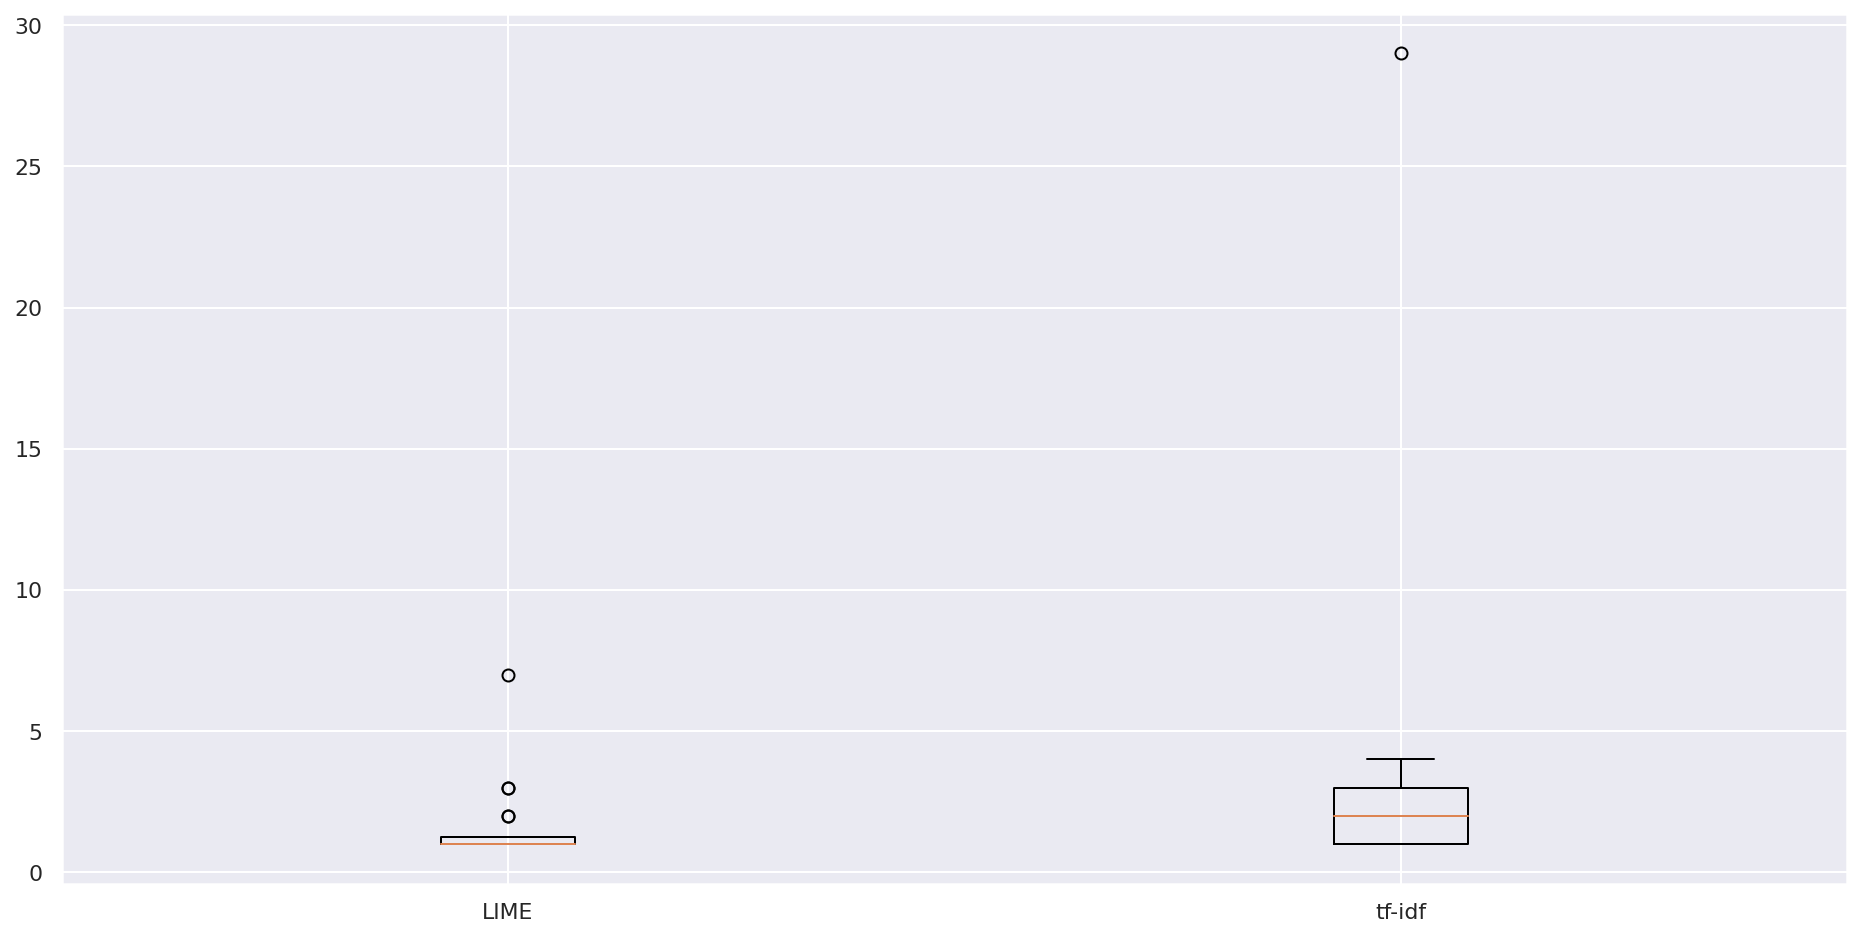

In [24]:
compare_boxplots(lime_k_recall, 
                 baseline_k_recall, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

**Metric 2**: maximum F1-score at k

In [25]:
ignore_ids = ['Q1484620', 'Q153721', 'Q383502', 'Q647093', 'Q971268', 'Q1067027', 'Q22713116']

In [26]:
min_k = sys.maxsize
min_name = None
for group_name, group_data in grouped_lime_df:
    num_terms = group_data.shape[0]
    if num_terms < min_k and group_name not in ignore_ids:
        min_name = group_name
        min_k = num_terms

In [27]:
min_k

34

In [28]:
lime_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_f1score_avg = [sum(col)/len(col) for col in zip(*lime_max_f1score)]

baseline_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_f1score_avg = [sum(col)/len(col) for col in zip(*baseline_max_f1score)]

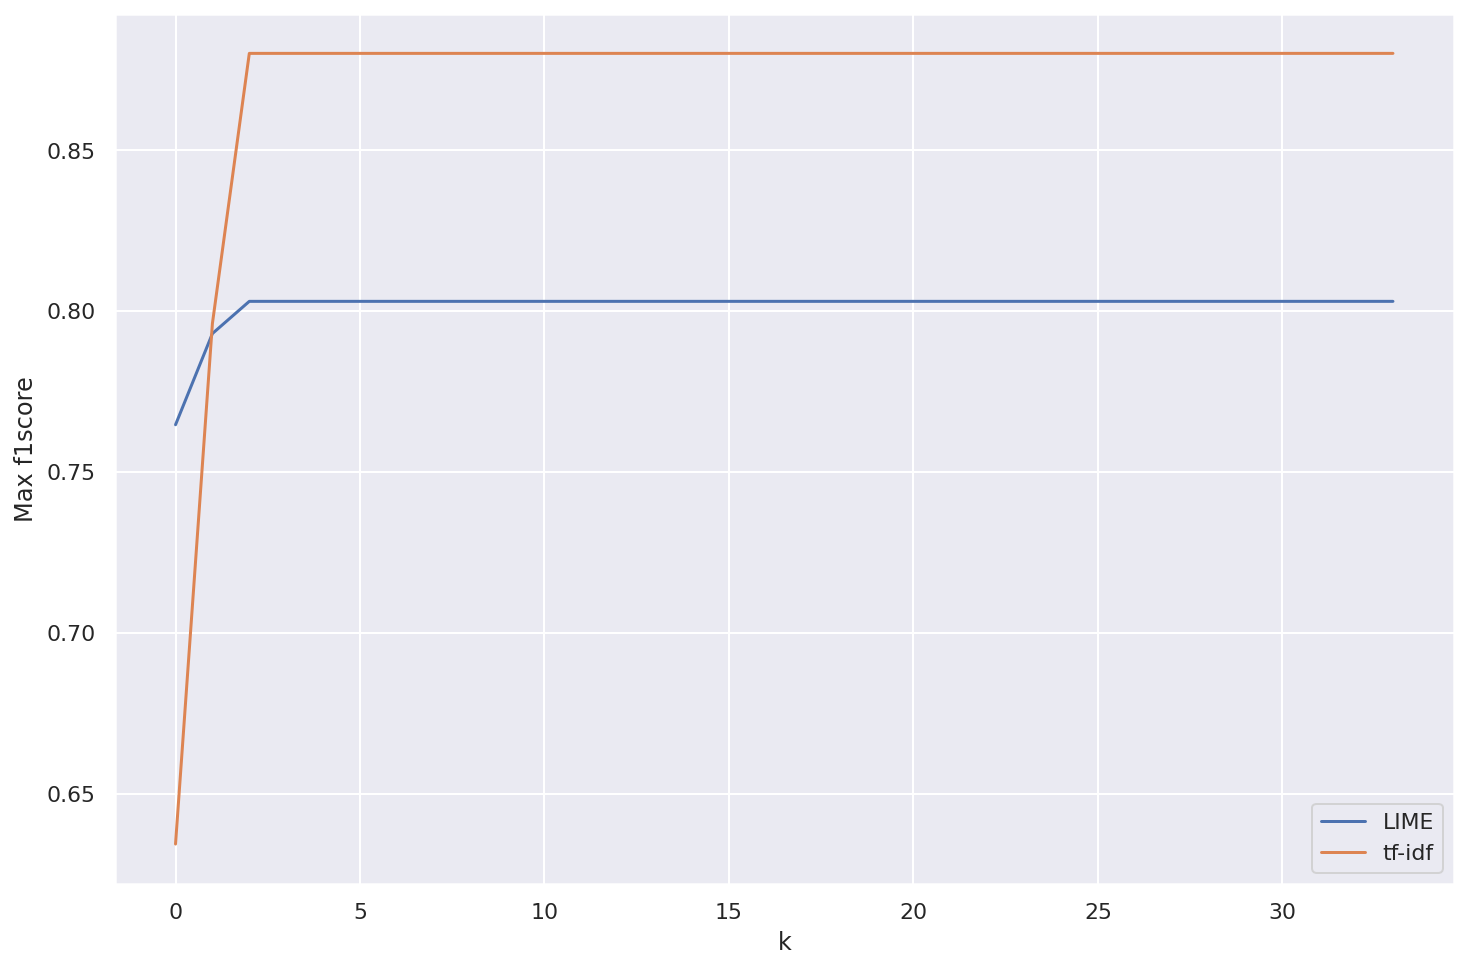

In [29]:
compare_lineplots(list(range(min_k)), 
                  lime_max_f1score_avg, 
                  baseline_max_f1score_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max f1score', 
                  use_plotly)

**Metric 3**: argmax f1-score

In [30]:
lime_argmax_f1score = [entry['argmax_f1score'] for entry in lime_metrics_list if entry['argmax_f1score']]
baseline_argmax_f1score = [entry['argmax_f1score'] for entry in baseline_metrics_list if entry['argmax_f1score']]

In [31]:
print(f'lime_argmax_f1score size: {len(lime_argmax_f1score)}')
print(f'baseline_argmax_f1score size: {len(baseline_argmax_f1score)}')

lime_argmax_f1score size: 2
baseline_argmax_f1score size: 10


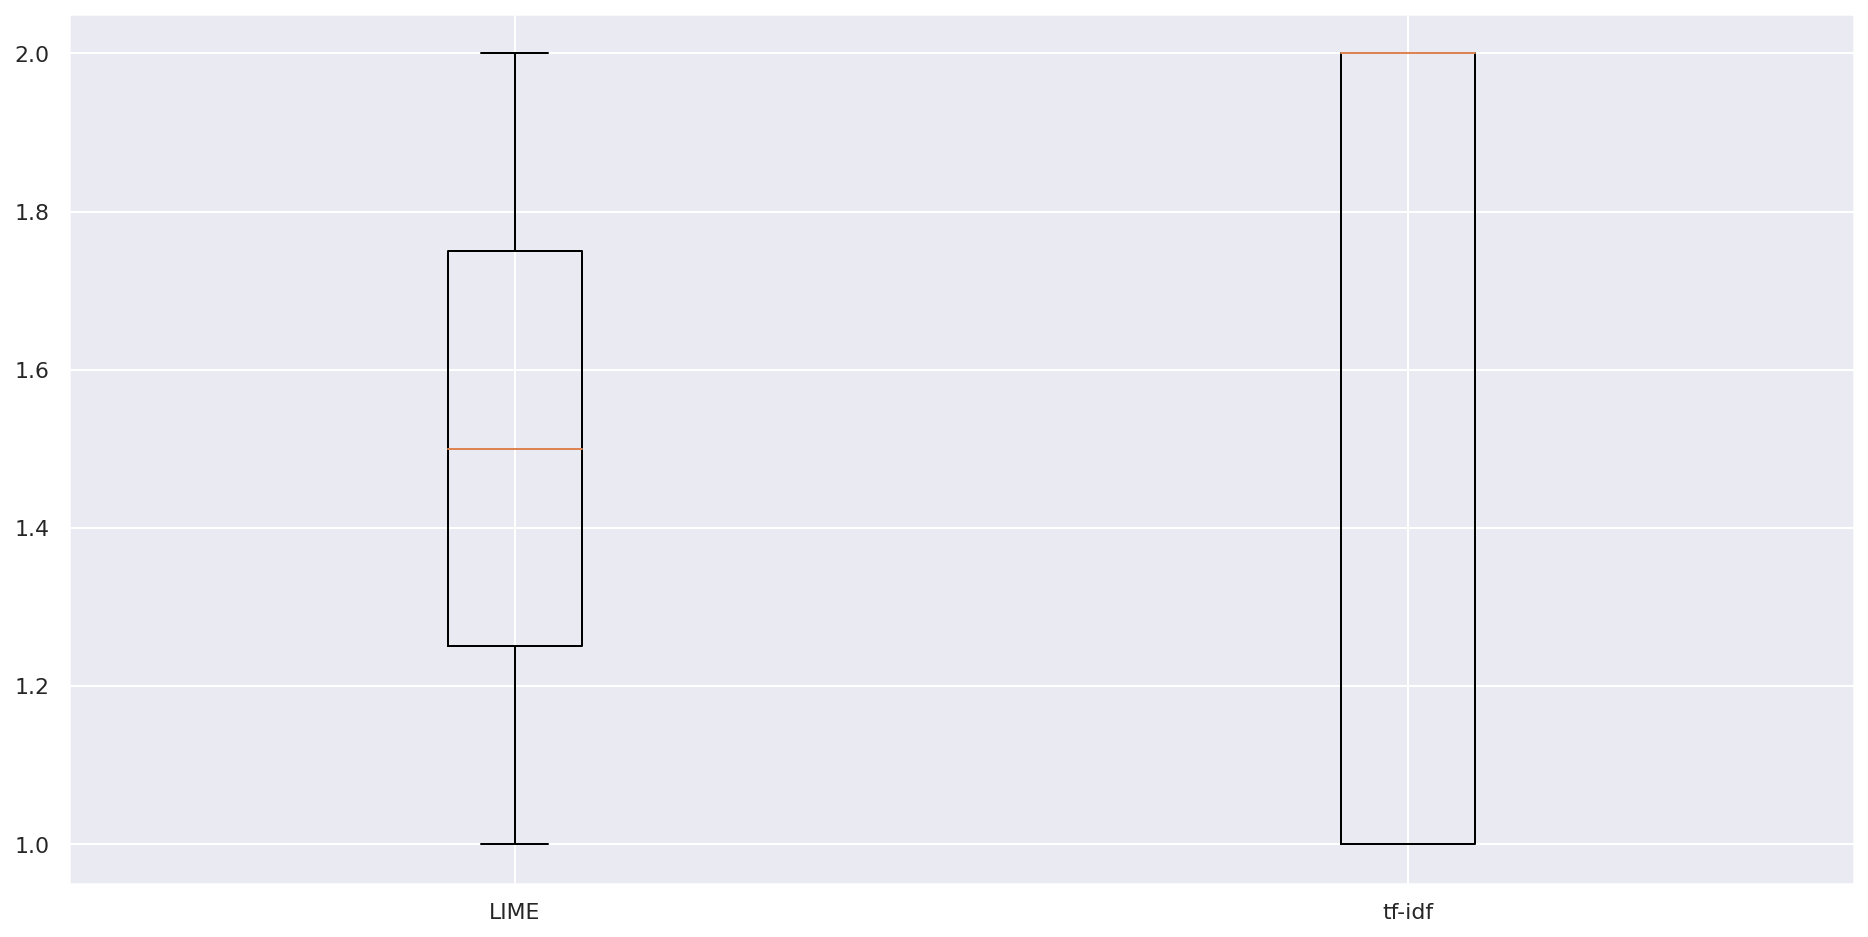

In [32]:
compare_boxplots(lime_argmax_f1score, 
                 baseline_argmax_f1score, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

**Metric 4**: maximum F2-score at k

In [33]:
lime_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_f2score_avg = [sum(col)/len(col) for col in zip(*lime_max_f2score)]

baseline_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_f2score_avg = [sum(col)/len(col) for col in zip(*baseline_max_f2score)]

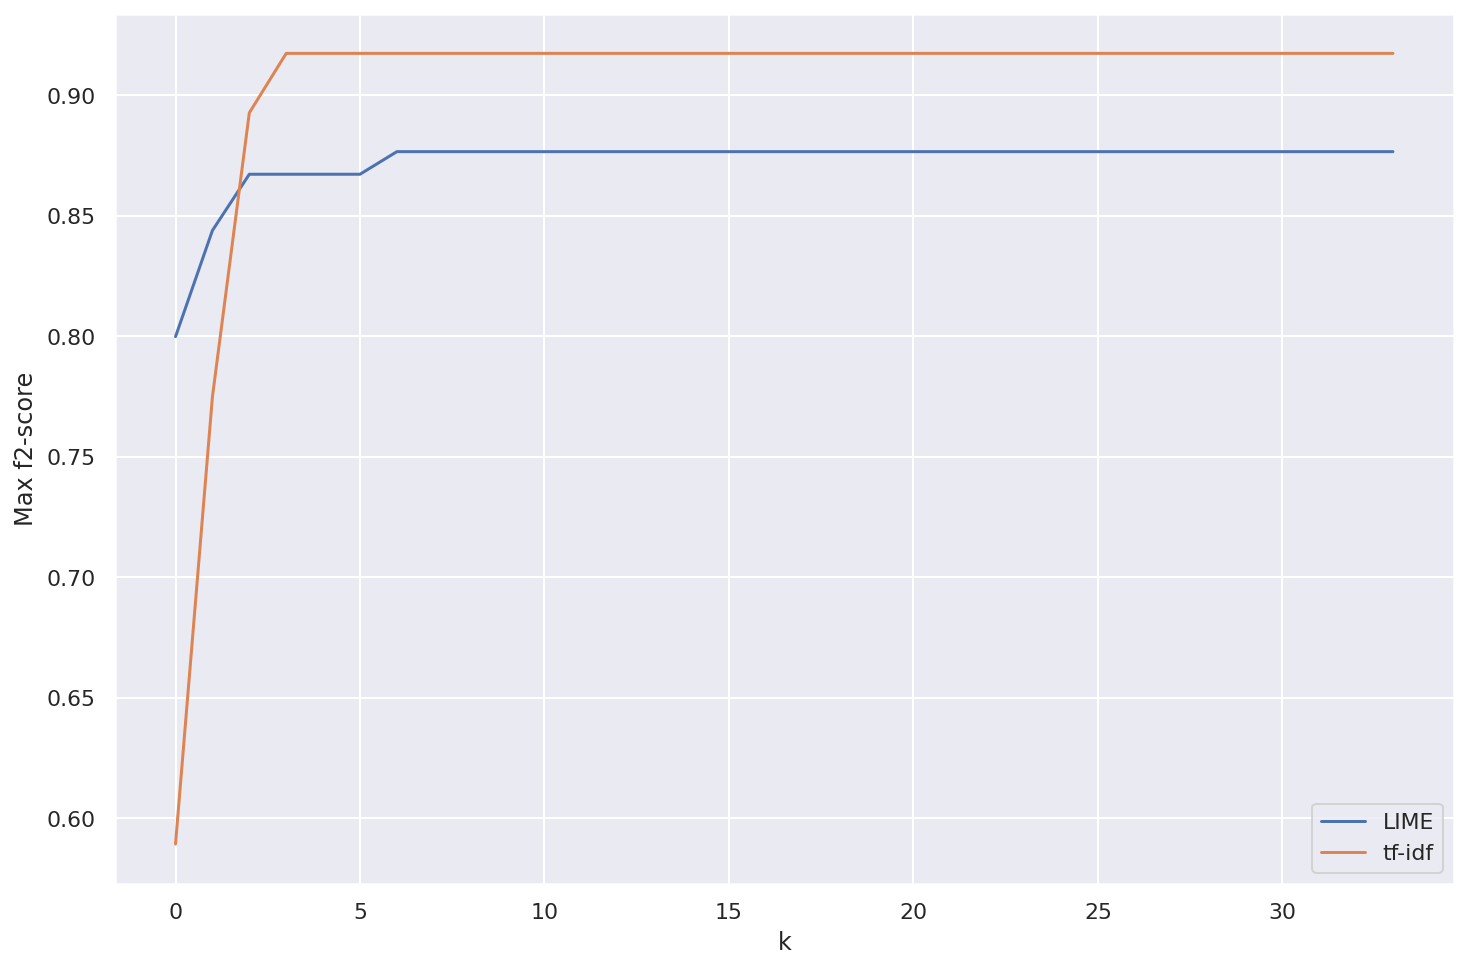

In [34]:
compare_lineplots(list(range(min_k)), 
                  lime_max_f2score_avg, 
                  baseline_max_f2score_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max f2-score', 
                  use_plotly)

**Metric 5**: maximum F0.5-score at k

In [35]:
lime_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_f05score_avg = [sum(col)/len(col) for col in zip(*lime_max_f05score)]

baseline_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_f05score_avg = [sum(col)/len(col) for col in zip(*baseline_max_f05score)]

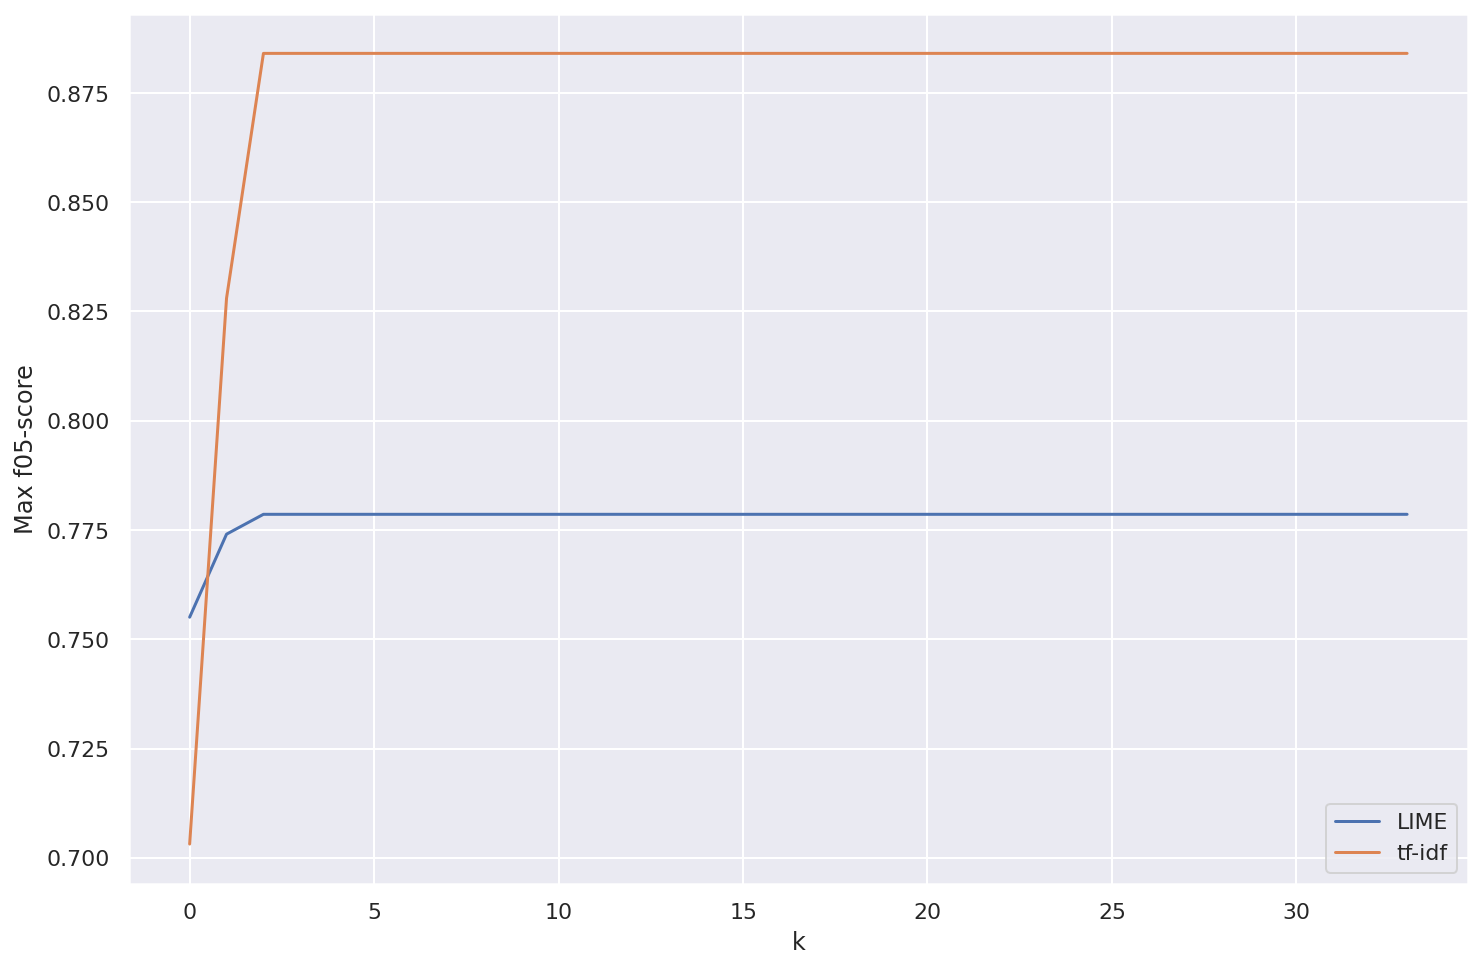

In [36]:
compare_lineplots(list(range(min_k)), 
                  lime_max_f05score_avg, 
                  baseline_max_f05score_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max f05-score', 
                  use_plotly)

**Metric 6**: `max(recall[i])` s.t `precision[i] > threshold` where `threshold = 0.9`

In [37]:
lime_max_recall = [entry['max_recall'] for entry in lime_metrics_list if entry['max_recall']]
baseline_max_recall = [entry['max_recall'] for entry in baseline_metrics_list if entry['max_recall']]

In [38]:
print(f'lime_max_recall size: {len(lime_max_recall)}')
print(f'baseline_max_recall size: {len(baseline_max_recall)}')

lime_max_recall size: 12
baseline_max_recall size: 15


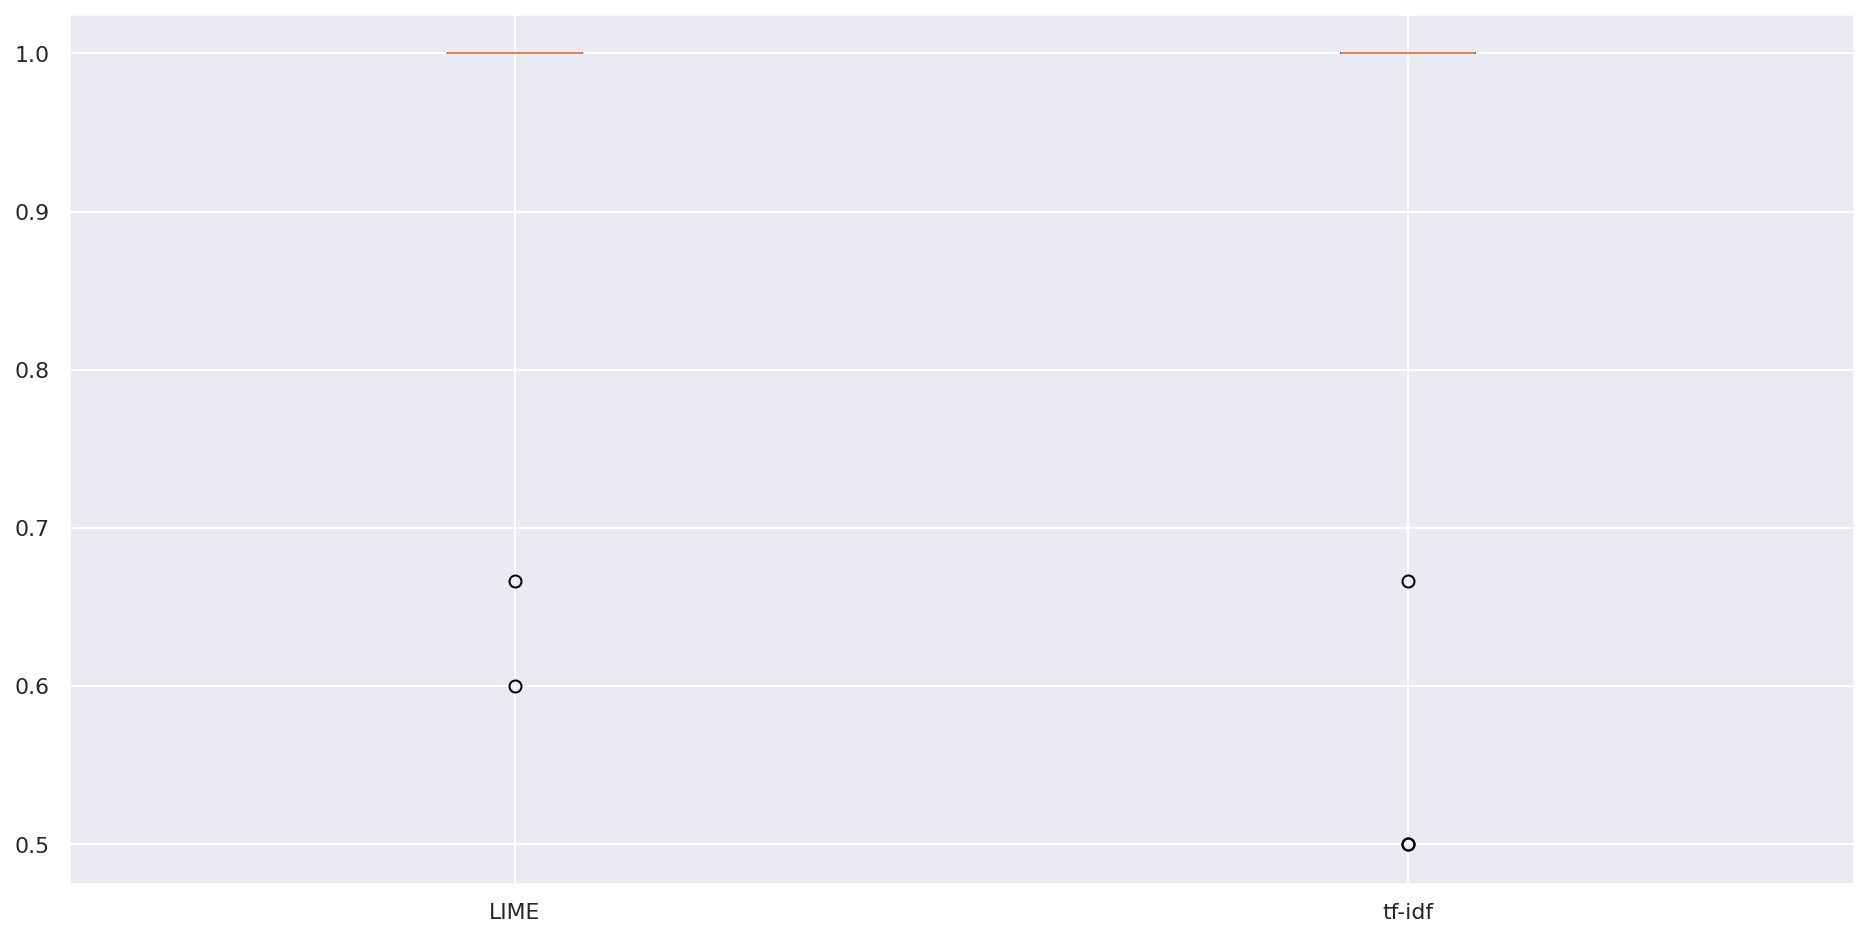

In [39]:
compare_boxplots(lime_max_recall, 
                 baseline_max_recall, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

**Metric 7**: `max(precision[i])` s.t `recall[i] > threshold` where `threshold = 0.9`

In [40]:
lime_max_precision = [entry['max_precision'] for entry in lime_metrics_list if entry['max_precision']]
baseline_max_precision = [entry['max_precision'] for entry in baseline_metrics_list if entry['max_precision']]

In [41]:
print(f'lime_max_precision size: {len(lime_max_precision)}')
print(f'baseline_max_precision size: {len(baseline_max_precision)}')

lime_max_precision size: 20
baseline_max_precision size: 20


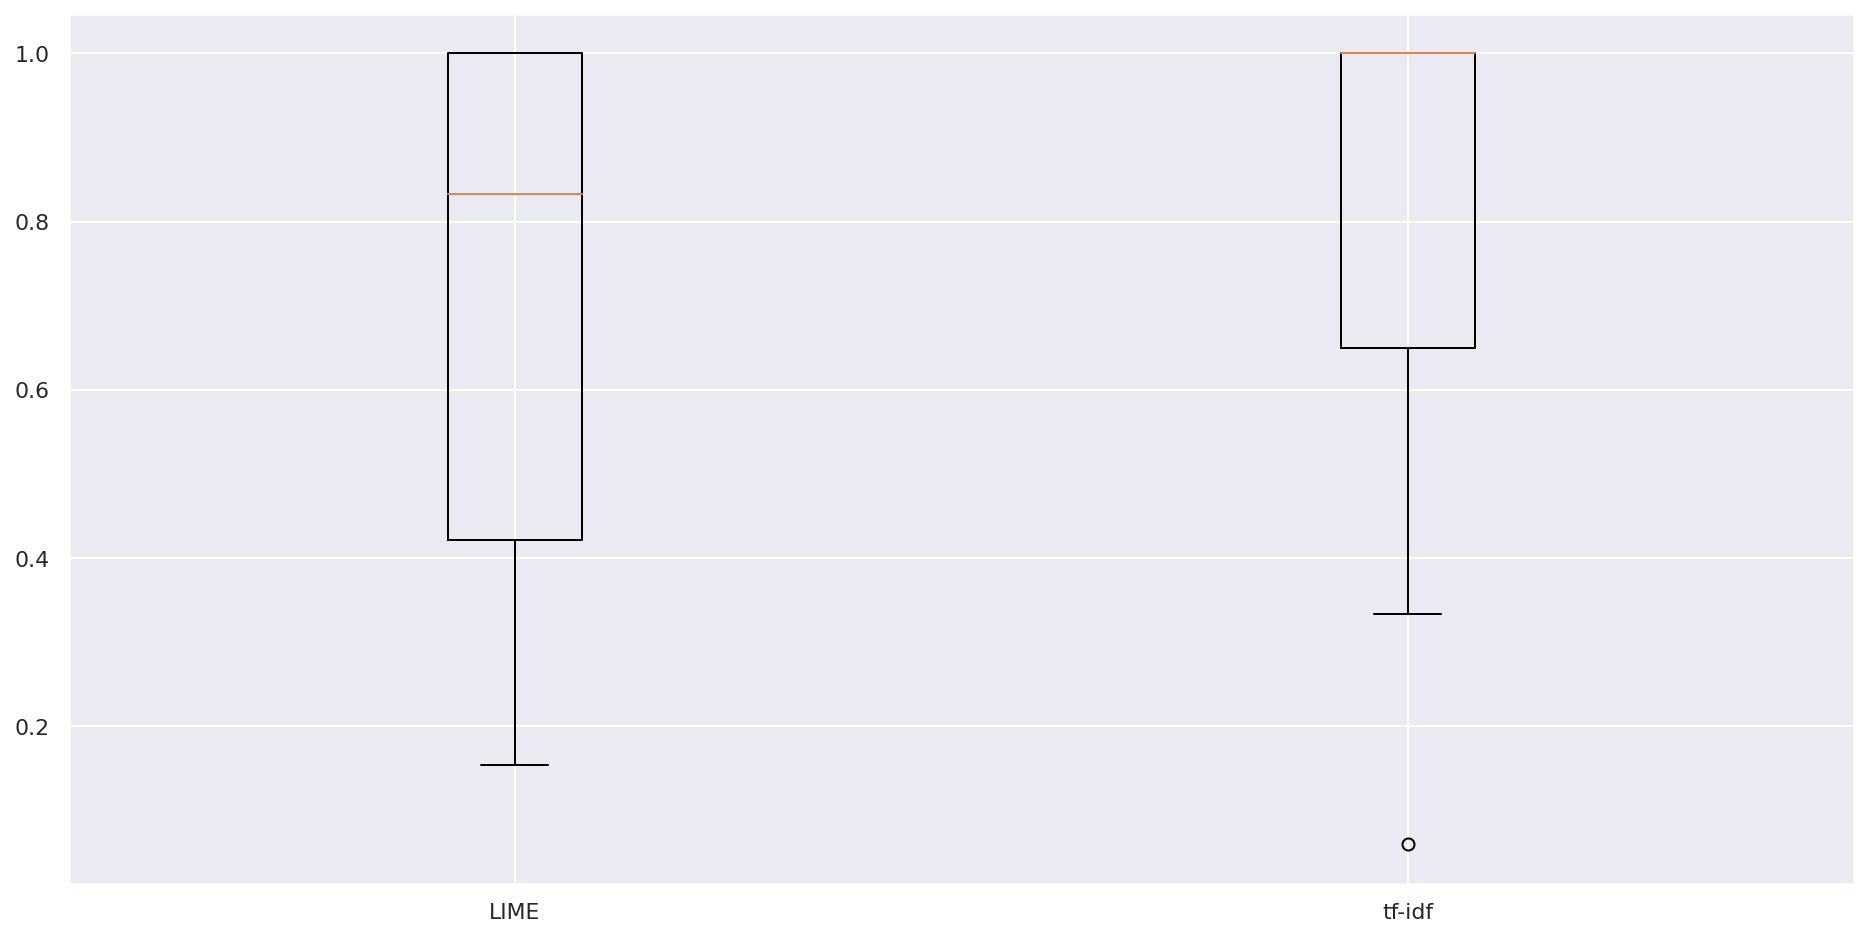

In [42]:
compare_boxplots(lime_max_precision, 
                 baseline_max_precision, 
                 'LIME', 
                 'tf-idf', 
                 use_plotly)

**Metric 8**: maximum recall at k

In [43]:
lime_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*lime_max_recall_at_k)]

baseline_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*baseline_max_recall_at_k)]

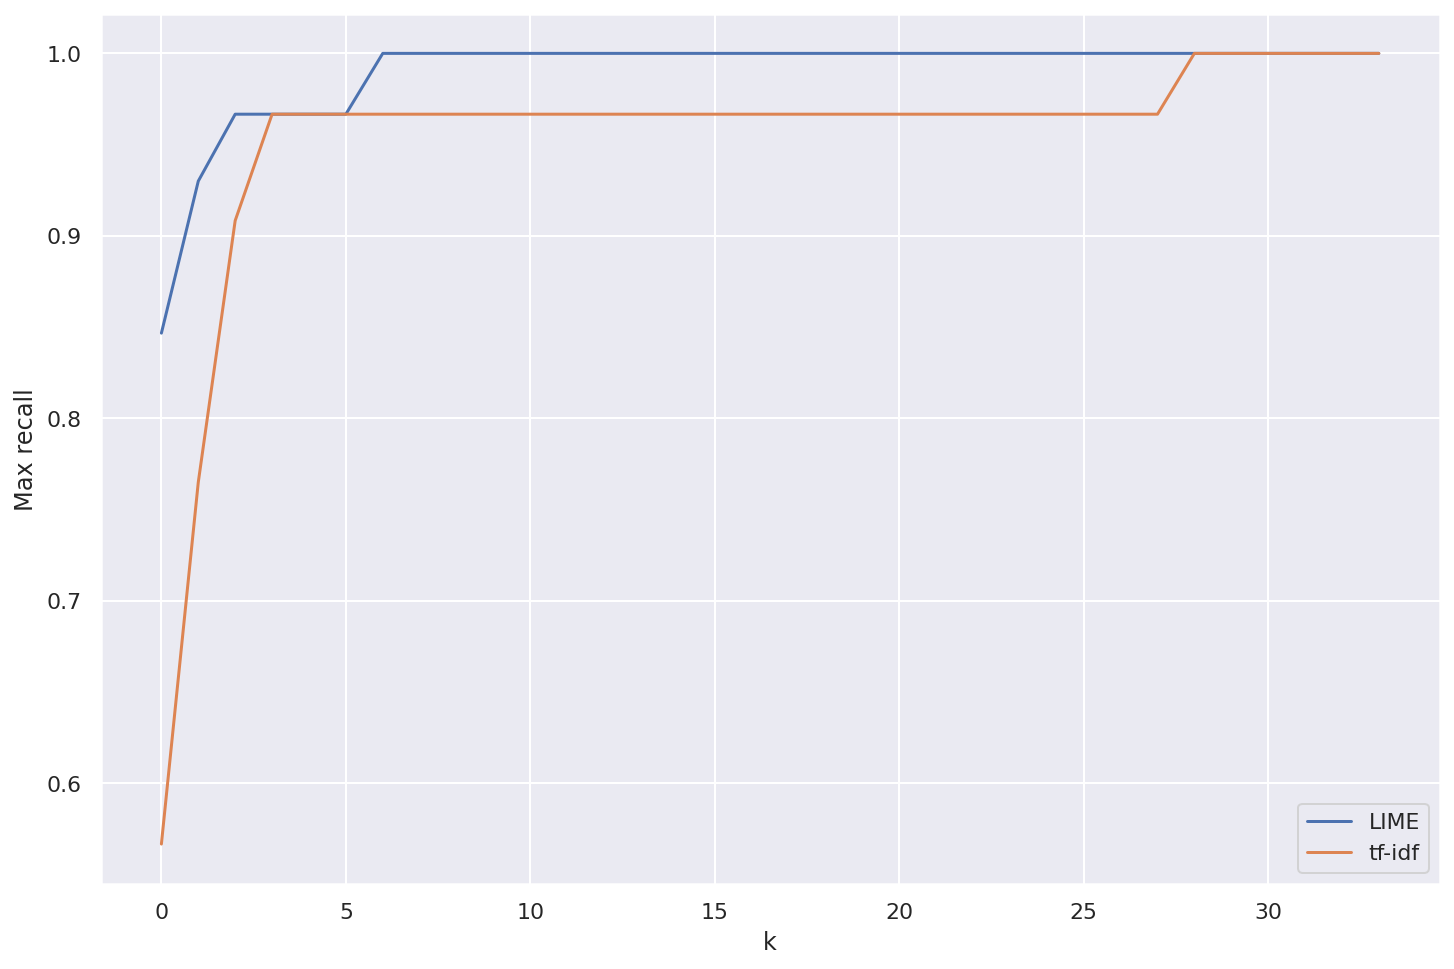

In [44]:
compare_lineplots(list(range(min_k)), 
                  lime_max_recall_at_k_avg, 
                  baseline_max_recall_at_k_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max recall', 
                  use_plotly)

**Metric 9**: maximum precision at k

In [45]:
lime_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in lime_metrics_list if entry['entity'] not in ignore_ids]
lime_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*lime_max_precision_at_k)]

baseline_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in baseline_metrics_list if entry['entity'] not in ignore_ids]
baseline_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*baseline_max_precision_at_k)]

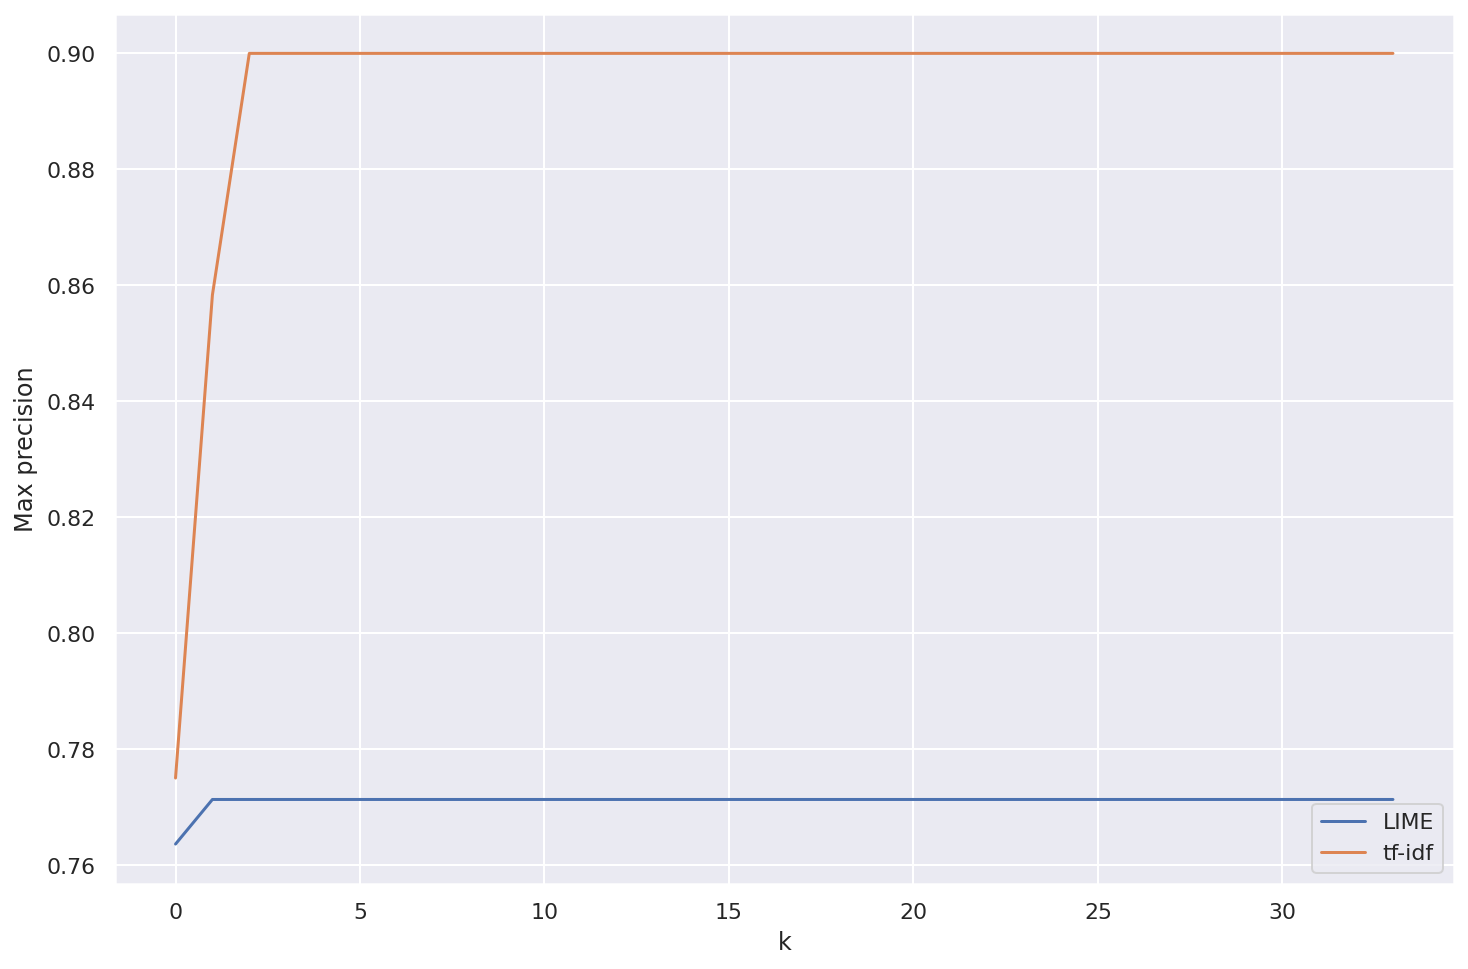

In [46]:
compare_lineplots(list(range(min_k)), 
                  lime_max_precision_at_k_avg, 
                  baseline_max_precision_at_k_avg,
                  'LIME', 
                  'tf-idf',
                  'k', 
                  'Max precision', 
                  use_plotly)

---

## Write top N terms to file

In [47]:
filename = 'top_n_alaska.xlsx'
filepath = os.path.join(root_dir, data_dir, rank_dir, filename)

In [48]:
top_n = 30

In [49]:
from training import TrainingCorpus

In [50]:
with pd.ExcelWriter(filepath) as writer:
    for group_name, group_data in grouped_lime_df:
        num_terms = min(group_data['term'].shape[0], top_n)
        lime_terms = group_data['term'].values[:num_terms]
        baseline_terms = grouped_baseline_df.get_group(group_name)['term'][:num_terms]
        target = ' '.join(TrainingCorpus.tokenize(gt_dict[group_name]))

        df = pd.DataFrame({'lime_term': lime_terms,
                           'baseline_term': baseline_terms,
                           'target': target})
        df.to_excel(writer,
                    sheet_name=group_name, 
                    index=False)   

---